In [3]:
# 1. Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.impute import SimpleImputer

import warnings
warnings.filterwarnings('ignore')


In [4]:
# 2. Load Dataset
df = pd.read_csv("Housing.csv")
df.head(), df.shape


(      price  area  bedrooms  bathrooms  stories mainroad guestroom basement  \
 0  13300000  7420         4          2        3      yes        no       no   
 1  12250000  8960         4          4        4      yes        no       no   
 2  12250000  9960         3          2        2      yes        no      yes   
 3  12215000  7500         4          2        2      yes        no      yes   
 4  11410000  7420         4          1        2      yes       yes      yes   
 
   hotwaterheating airconditioning  parking prefarea furnishingstatus  
 0              no             yes        2      yes        furnished  
 1              no             yes        3       no        furnished  
 2              no              no        2      yes   semi-furnished  
 3              no             yes        3      yes        furnished  
 4              no             yes        2       no        furnished  ,
 (545, 13))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 545 entries, 0 to 544
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   price             545 non-null    int64 
 1   area              545 non-null    int64 
 2   bedrooms          545 non-null    int64 
 3   bathrooms         545 non-null    int64 
 4   stories           545 non-null    int64 
 5   mainroad          545 non-null    object
 6   guestroom         545 non-null    object
 7   basement          545 non-null    object
 8   hotwaterheating   545 non-null    object
 9   airconditioning   545 non-null    object
 10  parking           545 non-null    int64 
 11  prefarea          545 non-null    object
 12  furnishingstatus  545 non-null    object
dtypes: int64(6), object(7)
memory usage: 55.5+ KB


<Axes: >

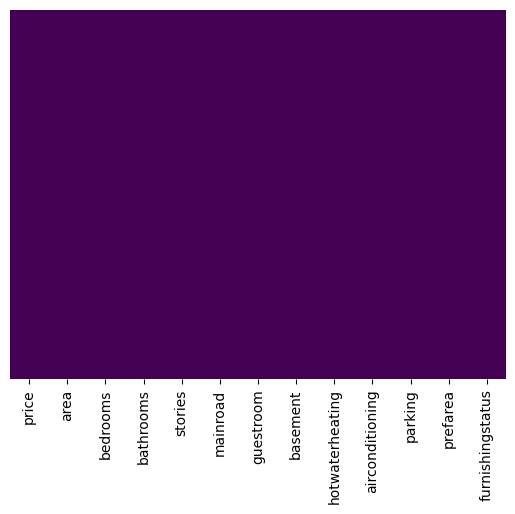

In [5]:
# 3. Explore & Understand Data
df.info()
df.describe()
sns.heatmap(df.isnull(), cbar=False, yticklabels=False, cmap='viridis')


In [6]:
# 4. Handle missing values

# a) Show missing value counts
missing = df.isnull().sum().sort_values(ascending=False)
missing[missing > 0]


Series([], dtype: int64)

In [7]:
# b) Impute numerical columns with median
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
imputer = SimpleImputer(strategy="median")
df[num_cols] = imputer.fit_transform(df[num_cols])


In [8]:
# c) Impute categorical columns with mode
cat_cols = df.select_dtypes(include=[object]).columns.tolist()
imputer_str = SimpleImputer(strategy="most_frequent")
df[cat_cols] = imputer_str.fit_transform(df[cat_cols])


In [9]:
# 5. Encode Categorical Variables
for col in cat_cols:
    df[col] = LabelEncoder().fit_transform(df[col].astype(str))


In [10]:
# 6. Feature Engineering (optional but helpful)
# Example: Transform skewed numeric features
skewed_feats = df[num_cols].apply(lambda x: x.skew()).sort_values(ascending=False)
high_skew = skewed_feats[abs(skewed_feats) > 0.75].index
for col in high_skew:
    df[col] = np.log1p(df[col])

# Another example: Add Bedrooms per House Ratio
if 'Bedrooms' in df.columns and 'Floors' in df.columns:
    df['BedPerFloor'] = df['Bedrooms'] / (df['Floors'] + 1)


In [17]:
# 7. Define Features and Target
y = df["price"]  # price column yahan hai
X = df.drop("price", axis=1)


In [18]:
# 8. Train/Test Split
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, random_state=42)


In [19]:
# 9. Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)


In [20]:
# 10. Train Models

# Random Forest
rf = RandomForestRegressor(n_estimators=200, random_state=42)
rf.fit(X_train_scaled, y_train)
rf_preds = rf.predict(X_valid_scaled)
rf_rmse = np.sqrt(mean_squared_error(y_valid, rf_preds))
print("RF RMSE:", rf_rmse)

# Gradient Boosting
gb = GradientBoostingRegressor(n_estimators=200, learning_rate=0.1, random_state=42)
gb.fit(X_train_scaled, y_train)
gb_preds = gb.predict(X_valid_scaled)
gb_rmse = np.sqrt(mean_squared_error(y_valid, gb_preds))
print("GB RMSE:", gb_rmse)


RF RMSE: 0.26450315510812
GB RMSE: 0.2582264616609113


Text(0.5, 1.0, 'Top 15 Feature Importances - Random Forest')

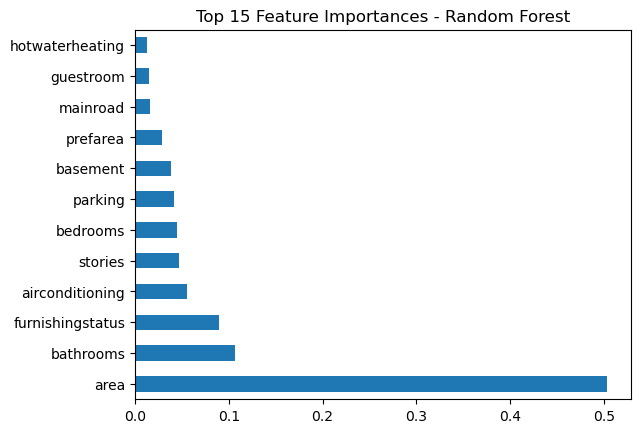

In [21]:
# 11. Feature Importance (Optional)
importances = pd.Series(rf.feature_importances_, index=X.columns)
importances.sort_values(ascending=False)[:15].plot(kind="barh")
plt.title("Top 15 Feature Importances - Random Forest")


In [22]:
# 12. Predict on full dataset or unseen test data
# Agar aapke paas test set hai to:
# X_test_scaled = scaler.transform(X_test)
# preds_test = (rf.predict(X_test_scaled) + gb.predict(X_test_scaled)) / 2

# Agar nahi hai, to hum full-data cross-validation kar sakte hain:
cv_scores = cross_val_score(rf, scaler.fit_transform(X), y, cv=5, scoring="neg_root_mean_squared_error")
print("CV RF RMSE:", -cv_scores.mean())


CV RF RMSE: 0.3012231535979011
